In [303]:
import numpy as np
import matplotlib.pyplot as plt
import pyedflib
from scipy.fft import rfft, rfftfreq
from scipy.signal import welch, stft, resample, butter, lfilter
from scipy.signal.windows import hann, hamming, blackman, boxcar
from pywt import cwt, frequency2scale

FIGURE_WIDTH = 20

In [304]:
def get_signal(path):
  reader = pyedflib.EdfReader(path)
  fs = reader.getSampleFrequency(0) # Sampling frequency
  channel_labels = [reader.getLabel(i) for i in range(reader.signals_in_file)]
  signal = reader.readSignal(channel_labels.index("EEG1"))
  duration = reader.file_duration
  reader.close()

  dt = 1 / fs # Sampling period
  time = np.arange(0, duration, dt) 

  return fs, signal, time, dt

signals = [
  ["eeg_1", *get_signal("dataset/bori_dataset_10s_eeg_1.edf")],
  ["eeg_2", *get_signal("dataset/bori_dataset_10s_eeg_2.edf")],
  ["eeg_3", *get_signal("dataset/bori_dataset_10s_eeg_3.edf")]
]

all_signals = [
  *signals,
  ["eeg_4", *get_signal("dataset/bori_dataset_10s_eeg_4.edf")],
  ["eeg_5", *get_signal("dataset/bori_dataset_10s_eeg_5.edf")],
  ["eeg_6", *get_signal("dataset/bori_dataset_10s_eeg_6.edf")],
  ["eeg_7", *get_signal("dataset/bori_dataset_10s_eeg_7.edf")],
  ["eeg_8", *get_signal("dataset/bori_dataset_10s_eeg_8.edf")],
  ["eeg_9", *get_signal("dataset/bori_dataset_10s_eeg_9.edf")],
  ["eeg_10", *get_signal("dataset/bori_dataset_10s_eeg_10.edf")]
]

# Time-domain and frequency-domain analysis

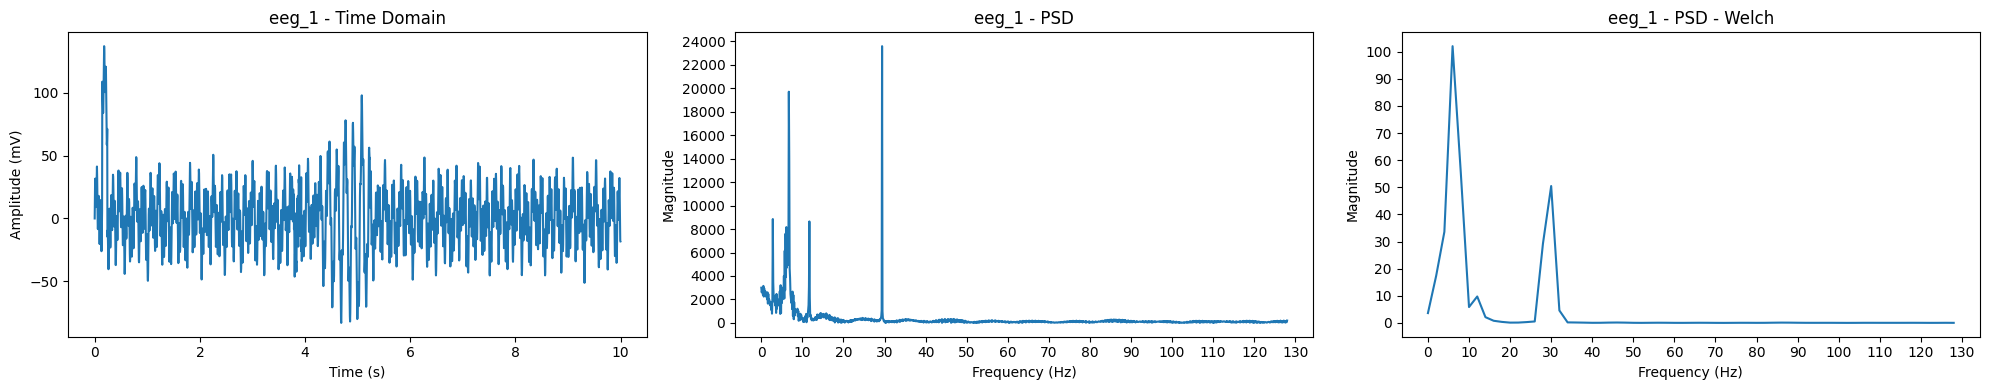

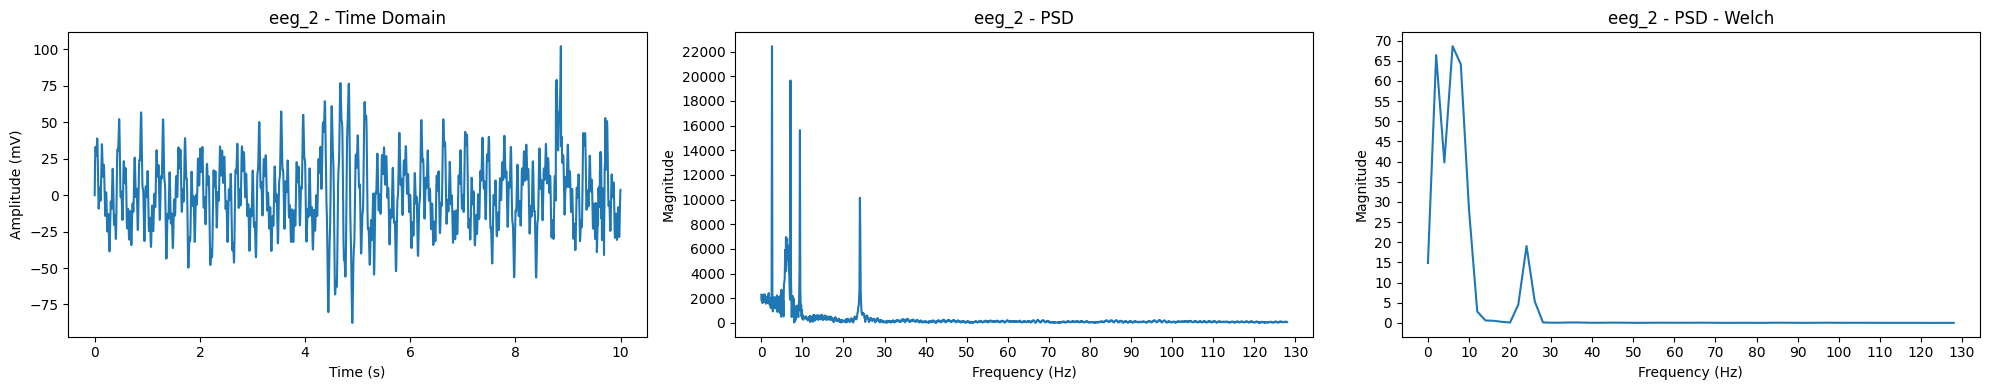

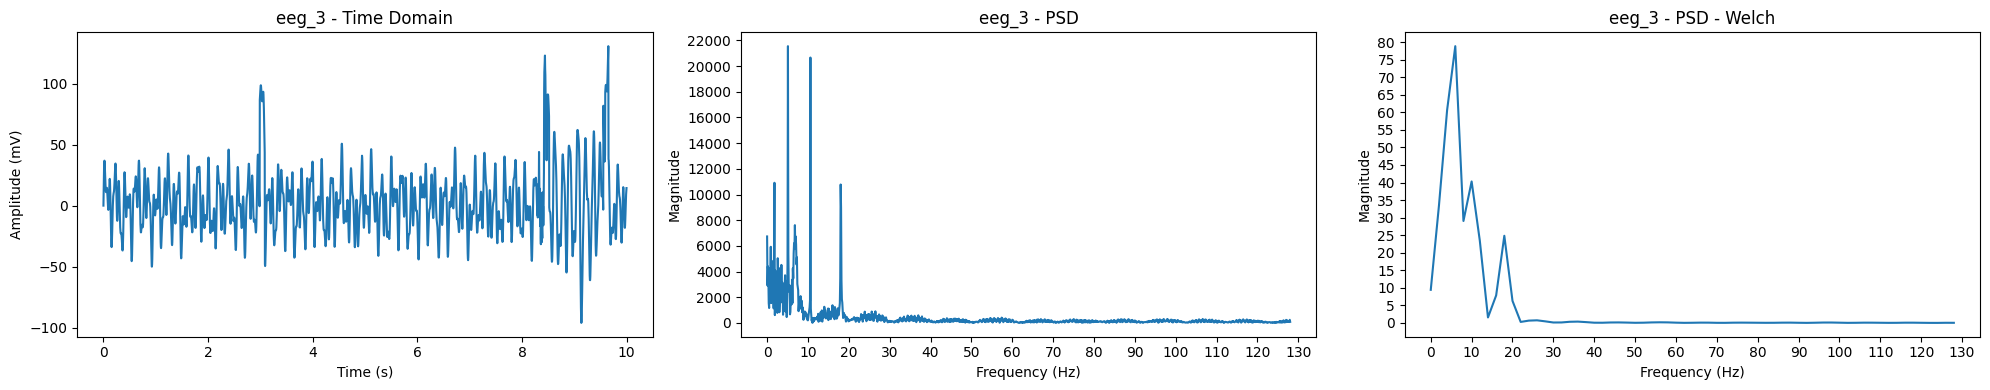

In [305]:
for sample, fs, signal, time, dt in signals: 
  fig, axes = plt.subplots(1, 3, figsize=(FIGURE_WIDTH, 4))

  # Time domain
  axes[0].plot(time, signal)
  axes[0].set_title(f"{sample} - Time Domain")
  axes[0].set_xlabel('Time (s)')
  axes[0].set_ylabel('Amplitude (mV)')

  # Frequency Domain
  Y = rfft(signal)
  abs_Y = np.abs(Y)

  frequencies = rfftfreq(time.size, dt)

  axes[1].plot(frequencies, abs_Y)
  axes[1].set_title(f"{sample} - PSD")
  axes[1].set_xlabel("Frequency (Hz)")
  axes[1].set_ylabel("Magnitude")
  axes[1].locator_params(axis="y", nbins=20) 
  axes[1].locator_params(axis="x", nbins=20) 

  # Frequency Domain - Welch 
  frequencies, psd = welch(
      signal,
      fs=fs,
      nperseg=128,
  )

  axes[2].plot(frequencies, psd)
  axes[2].set_title(f"{sample} - PSD - Welch")
  axes[2].set_xlabel("Frequency (Hz)")
  axes[2].set_ylabel("Magnitude")
  axes[2].locator_params(axis="y", nbins=20) 
  axes[2].locator_params(axis="x", nbins=20) 

  plt.tight_layout()
  plt.show()

https://en.wikipedia.org/wiki/Electroencephalography

- "dataset/bori_dataset_10s_eeg_1.edf" - The sample shows high activity around the 7Hz Theta band, indicating a drowsy state of the patient. With similar activity around the 30hz Beta band indicating the patient awake and in an active thinking state.
- "dataset/bori_dataset_10s_eeg_2.edf" - The sample shows more activity in the Delta, Theta and Alpha bands, indicating the patient in a sleep/slow waking state.
- "dataset/bori_dataset_10s_eeg_3.edf" - The sample shows the same as sample 2. More activity in the Delta, Theta and Alpha bands, indicating the patient in a sleep/slow waking state. With a higher occurence of Theta band, indicating a more drowsy patient.

Both show that ordering/sequence is the difference between correctly understanding the results and not.    
For example Theta -> Alpha -> Beta might indicate a waking up sequence, whereas Delta -> Beta might indicate something else entirely.  
Hence why the temporal aspect being added in STFT and CWT is essential to understand what is going on.  
Methods like Welch give us a much smoother averaged measure.

# STFT and CWT analysis

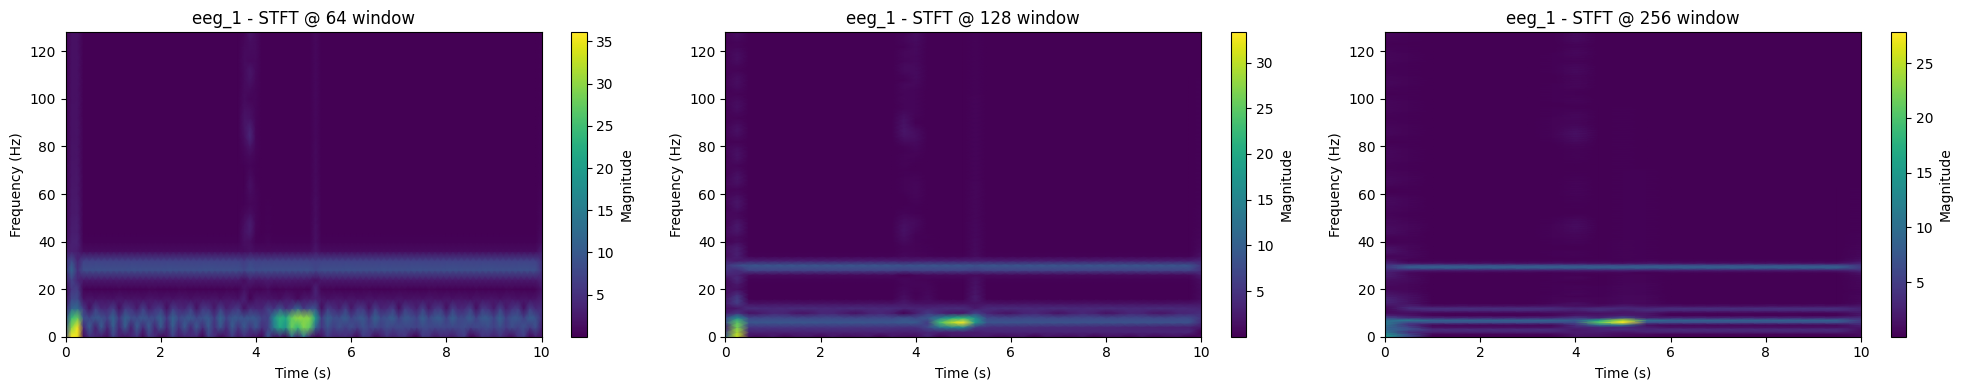

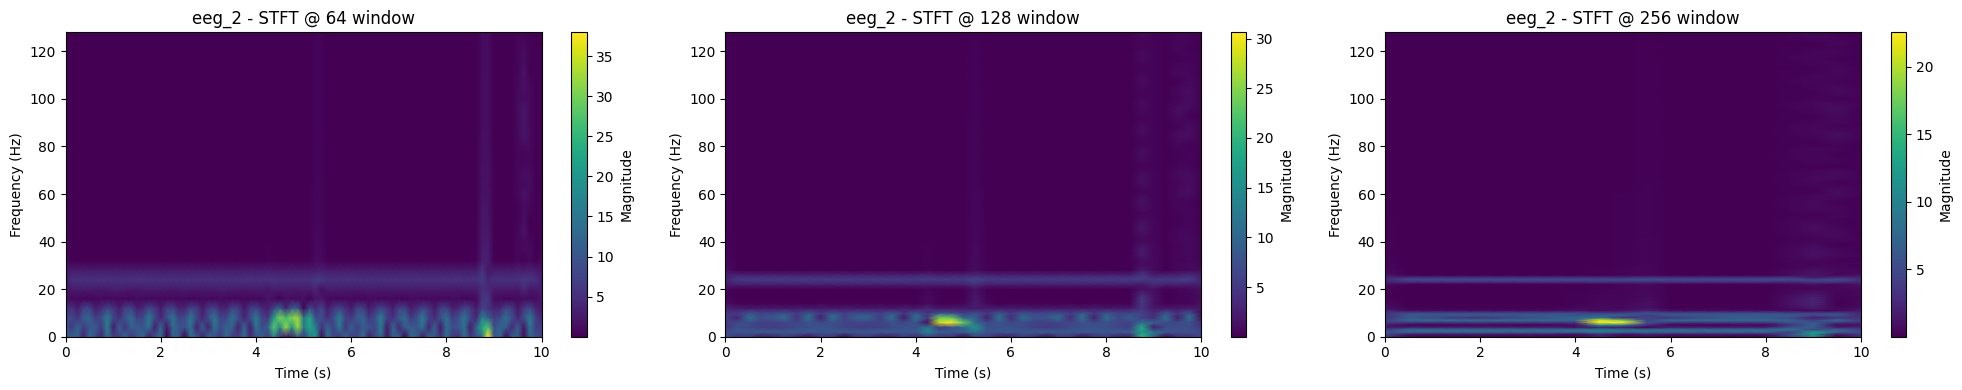

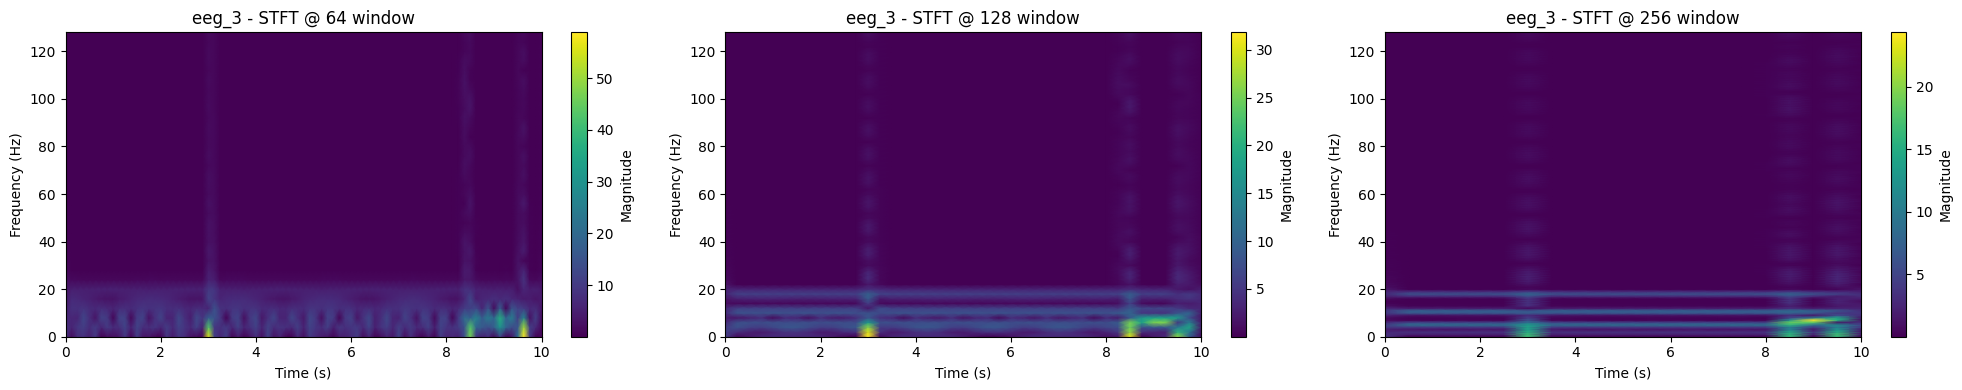

In [306]:
for sample, fs, signal, time, dt in signals: 
  window_sizes = [64, 128, 256]
  fig, axes = plt.subplots(1, len(window_sizes), figsize=(FIGURE_WIDTH, 4))

  for ax, window_size in zip(axes, window_sizes):
    ft, tt, st = stft(
        signal,
        fs=fs,
        window=hann(window_size),
        nperseg=window_size,
        return_onesided=True,
        scaling="spectrum"
    )
    abs_st = np.abs(st)

    ax.set_title(f"{sample} - STFT @ {window_size} window")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Frequency (Hz)")

    colormesh = ax.pcolormesh(tt, ft, abs_st, shading="gouraud")
    plt.colorbar(colormesh, ax=ax, label="Magnitude")
  
  plt.tight_layout()
  plt.show()

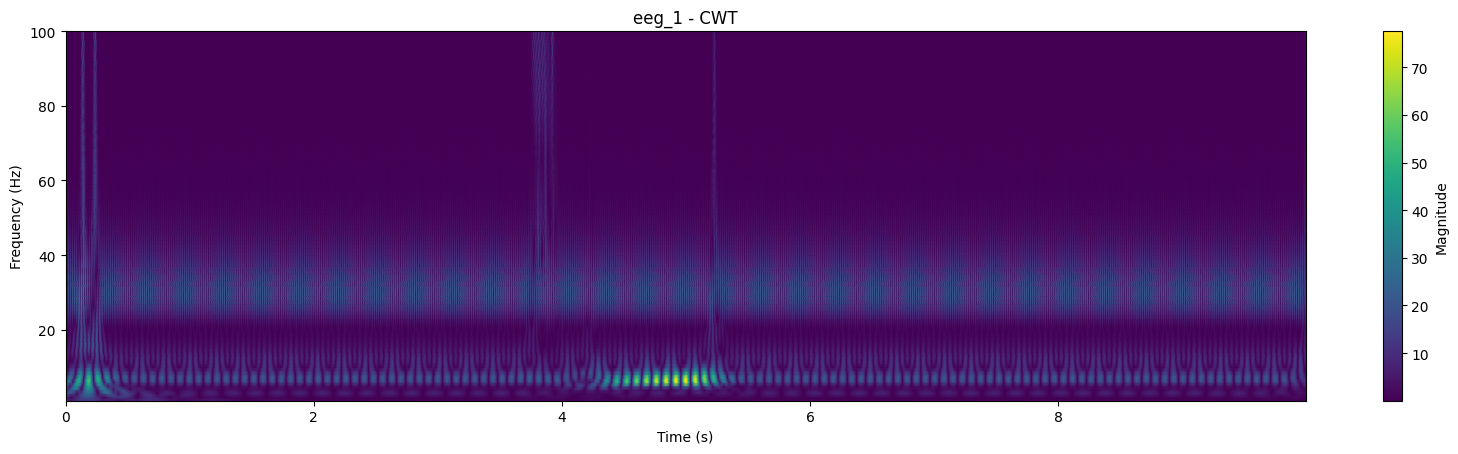

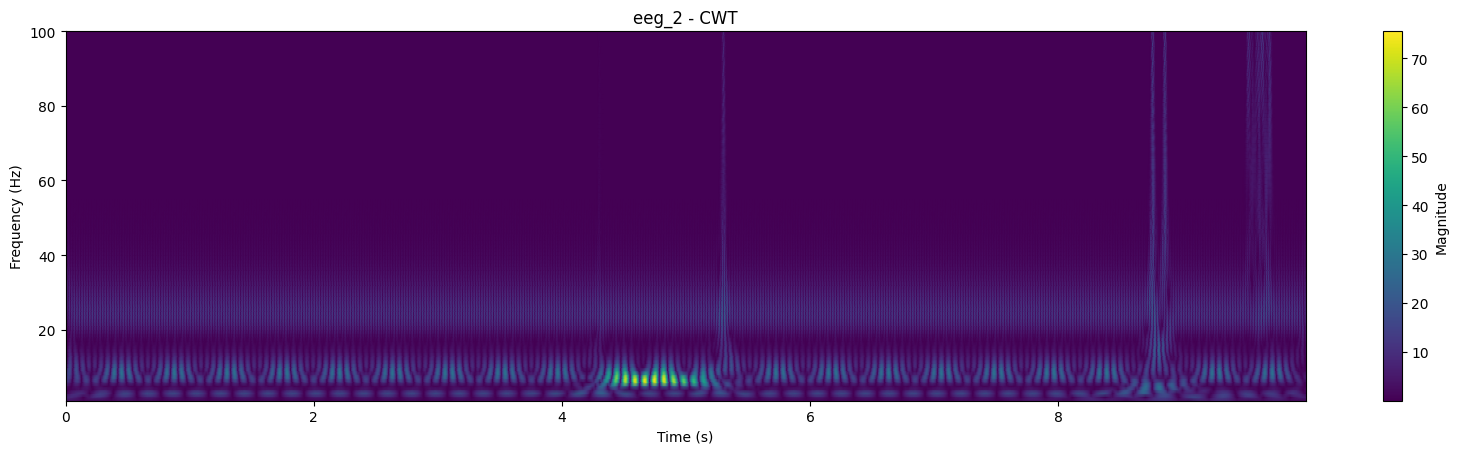

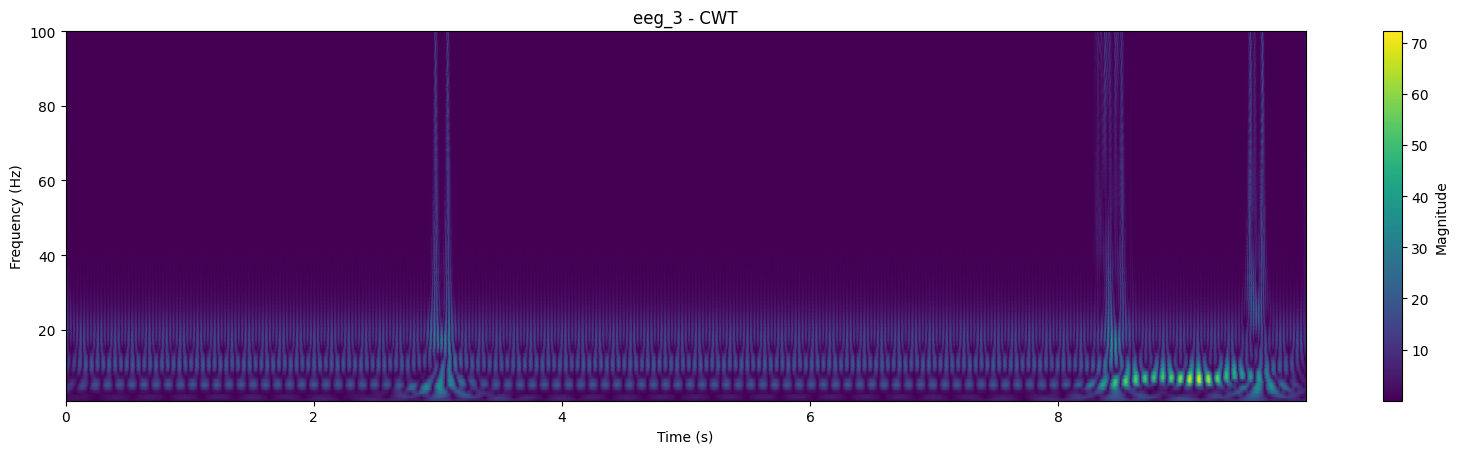

In [307]:
for sample, fs, signal, time, dt in signals: 
  wavelet = "morl"

  freqs = np.linspace(1, 100, 100) / fs
  scales = frequency2scale(wavelet, freqs)

  cwtmatrix, frequencies = cwt(signal, scales, wavelet, sampling_period=dt)

  abs_cwtmatrix = np.abs(cwtmatrix)
  norm_cwtmatrix = abs_cwtmatrix / np.sqrt(scales[:, np.newaxis])

  plt.figure().set_figwidth(FIGURE_WIDTH)
  plt.pcolormesh(time, frequencies, norm_cwtmatrix, shading="gouraud")
  plt.title(f"{sample} - CWT")
  plt.ylabel("Frequency (Hz)")
  plt.xlabel("Time (s)")
  plt.colorbar(label="Magnitude")
  plt.show()

The FFT clearly points out which frequencies are found most and how powerful they are.  
However as mentioned above timing in EEG is critical which FFT doesnt give us, but something that the Short Time Fourier Transform begins to fix.  

The EEG bands are pretty clearly split with little overlap so we're not focussed on a high level of precision here, something boxcar would be good for.  
Hann gives us a nice tradeoff between precision and spectral leakage.  
Using blackman would be overkill here and would not appear to warrant the tradeoff of spectral leakage and removing more/augmenting the original data at the edges.  

After testing with multiple window sizes 128 samples appear to mix the best for this usecase.  
It shows a much clearer split of frequency bands but also retains much of the time and magnitude data, whereas 256 samples start to loose more of that information.   
So it appears the best tradeoff for the EEG data, ensuring you can see between the different bands but also being small enough to capture quick eye blinks @ 100-150ms.  

Because of the varying frequency bands, STFT outlines the tradeoff you have to make between representing time vs frequency.  
This is very evident in the STFT window comparions. 64 samples would be great but it blurs frequencies.  
Enter Continuous wavelet transform to the rescue.  
It clearly shows a significant improvement in representing magnitude, time and frequency data. You can very clearly see when events start and stop and how powerful they were.  
It shows much sharper features and clearer frequency respresentation compared to ShortTime.  
Morlet most closely matches the EEG shape of slow smooth repeating waves.  
Testing against Mexican Hat and Haar prove they are for big spikes or a blocky profile and what we have here. 
Mexican Hat may be better for catching isolated spikes in a smaller frequency range.

# Sampling Theorem and Aliasing

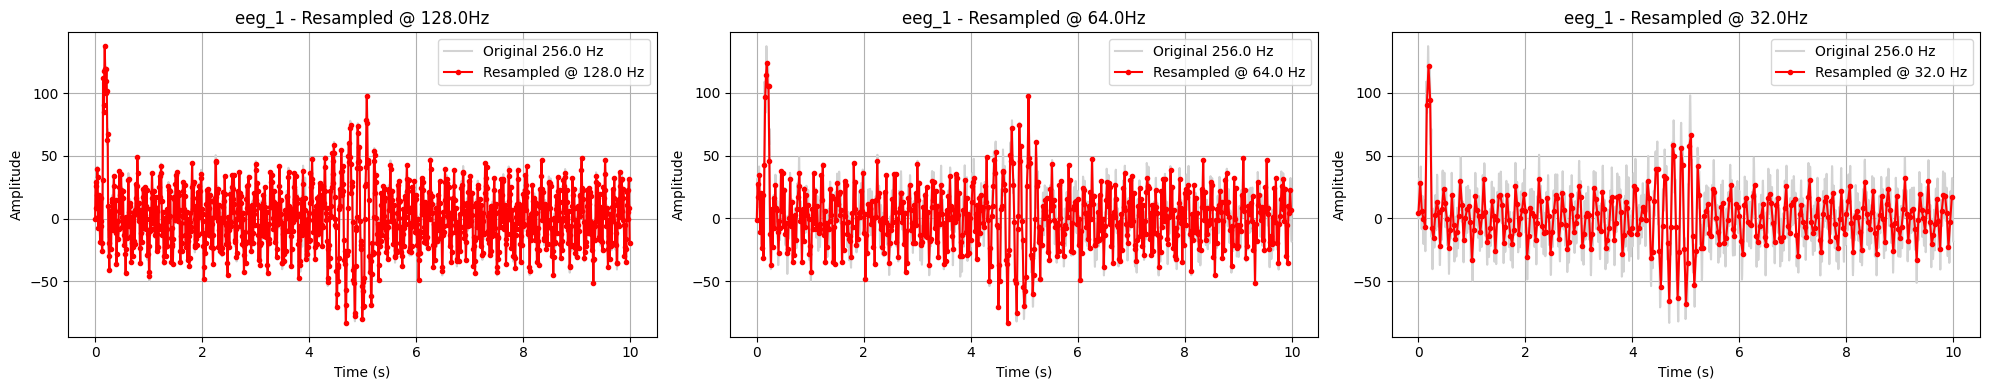

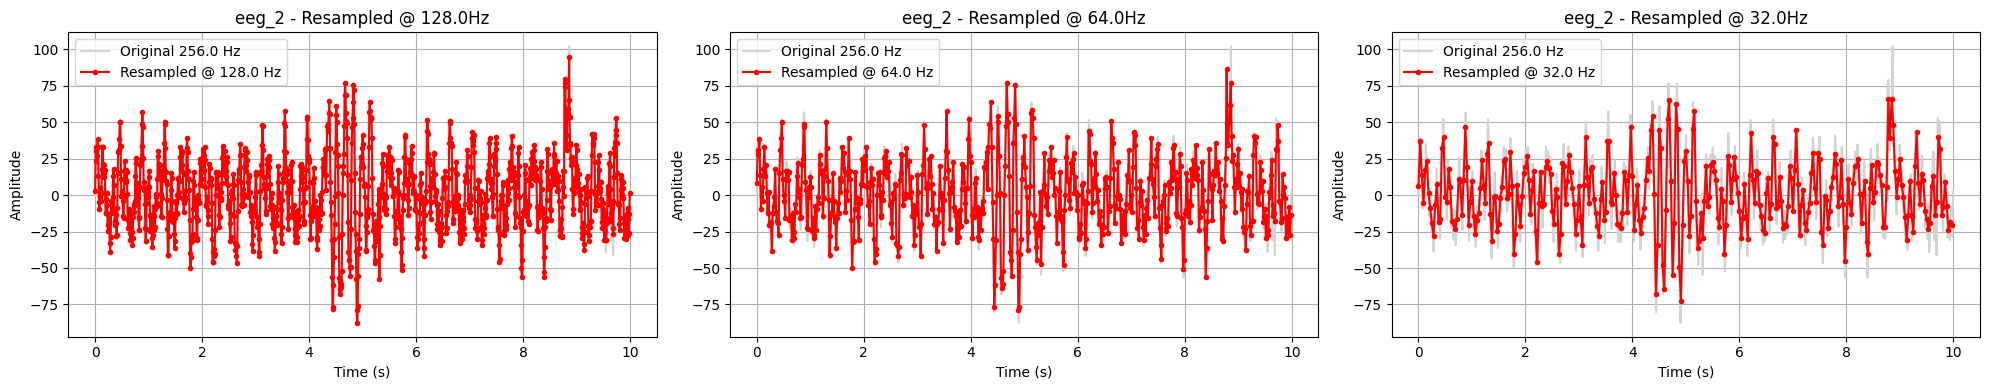

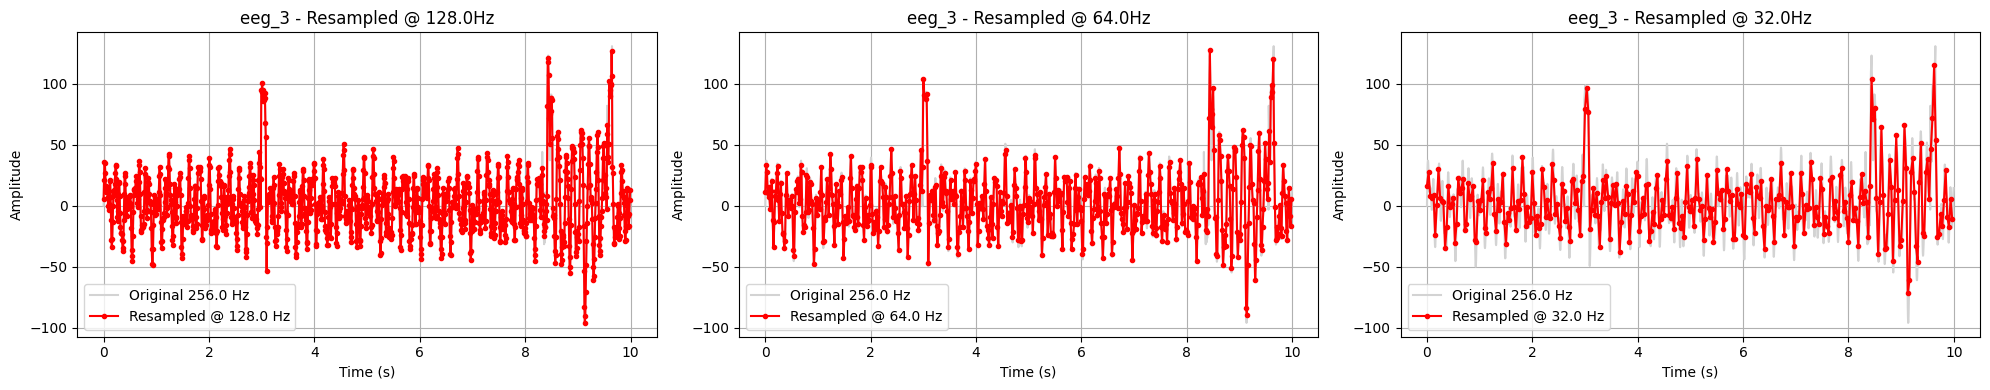

In [308]:
for sample, fs, signal, time, dt in signals: 
  f_max = fs / 2
  resampled_frequencies = [
    f_max, 
    f_max * .5, 
    f_max * .25,  
  ]

  fig, axes = plt.subplots(1, len(resampled_frequencies), figsize=(FIGURE_WIDTH, 4))

  for ax, resampled_frequency in zip(axes, resampled_frequencies):
    resampled_num = int(len(signal) * (resampled_frequency / fs))
    resampled_signal = resample(signal, resampled_num)

    time_2 = np.arange(len(signal)) / fs
    resampled_signal_time = np.arange(resampled_num) / resampled_frequency

    ax.plot(time_2, signal, "lightgray", label=f"Original {fs} Hz")
    ax.plot(resampled_signal_time, resampled_signal, "r.-", label=f"Resampled @ {resampled_frequency} Hz")
    ax.set_title(f"{sample} - Resampled @ {resampled_frequency}Hz")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.legend()
    ax.grid(True)

  plt.tight_layout()
  plt.show()

When resampling to half the Nyguist - 64Hz the effects of aliasing begin to become apparant, you can clearly see the resampled signal has less amplitude than the original and begins to loose the high frequency components like Beta.   
Then when resampling to 32Hz the resampled signal barely resembles the original, it is missing most of the key details between points.   
Higher frequency parts are aliased first while lower frequency parts keep their shape for longer when downsampling.   
Given the highest frequency of the EEG samples is roughly 50Hz, meaning 100Hz sampling rate would keep all the details which is proven above in the 100Hz sample graph.

The Nyguist-Shannon sampling theorem explains that to accurately represent the pattern/features of a signal, the sampling rate must be at least twice the highest frequency in the signal. fs >= 2 * f_max.   
So in the EEG samples, the signal is sampled at 256Hz, which means our Nyguist frequency (the highest we can capture) is 128Hz as Nygyust Frequency is fs / 2.  
If the sampling rate falls below the Nyguist rate then aliasing occurs, which is where information/points are lost and instead appear as lower frequencies as they fold back.

# Filtering

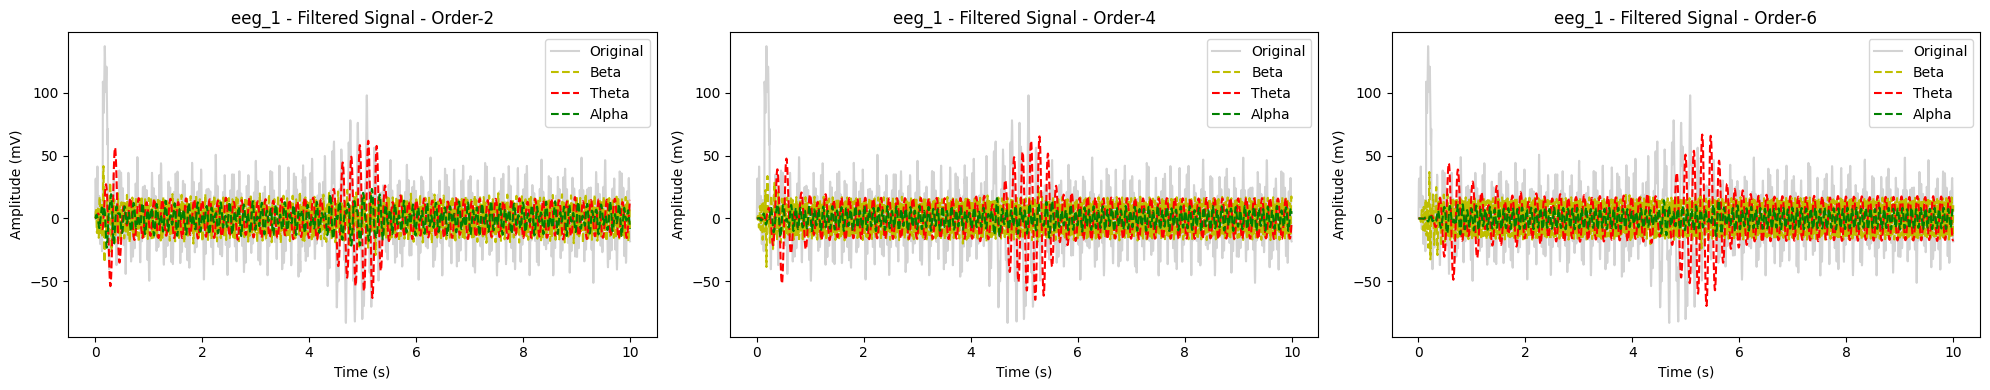

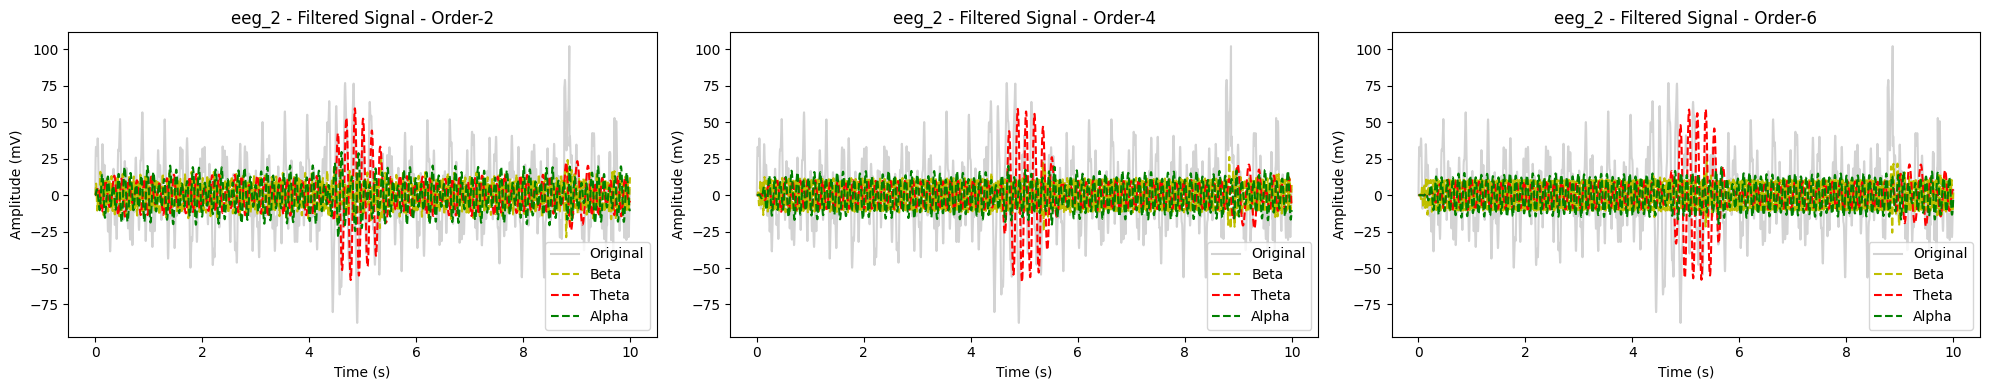

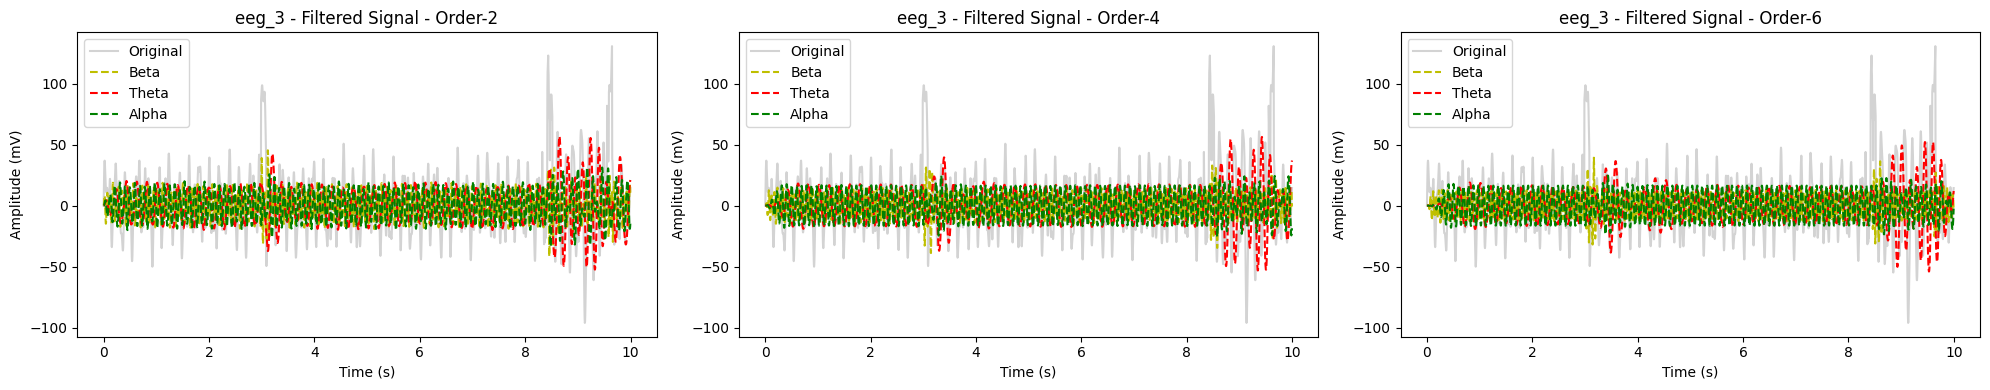

In [309]:
def filter(order, low, high):
    b, a = butter(order, [low, high], btype="bandpass", fs=fs)
    return lfilter(b, a, signal)

for sample, fs, signal, time, dt in signals: 
  orders = [
    2, 
    4, 
    6,  
  ]

  fig, axes = plt.subplots(1, len(orders), figsize=(FIGURE_WIDTH, 4))

  for ax, order in zip(axes, orders):
    ax.plot(time, signal, "lightgray", label="Original")
    ax.plot(time, filter(order, 13, 30), "y--", label="Beta")
    ax.plot(time, filter(order, 4, 7), "r--", label="Theta")
    ax.plot(time, filter(order, 8, 13), "g--", label="Alpha")
    ax.set_title(f"{sample} - Filtered Signal - Order-{order}")
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Amplitude (mV)')
    ax.legend()

  plt.tight_layout()
  plt.show()

I used a bandpass filter to capture only certain EEG band ranges which have a start end end i.e. Beta, Theta, Alpha etc.  
Given the split between each band has is pretty clear, this makes Butterworth the ideal choice, as we aren't worried about a more gradual rolloff.  
Something like Chebyshev would be a poor choice as we'd have to compromise and accept ripples and a disorted signal.  

Order 4 returns the best result for this dataset. It isolates the bands the best.  
As you can see an order 2 shows contamination of other bands in the theta spikes in eeg_1.  
Whereas order 4 removes this contamination also found in the other signals.  
Order 6 looks almost identical to order 4, so shows little reason to use for no benefit and a larger computational cost.

# Artifact Detection

## Seizures

In [310]:
def seizures(signal):
  low_frequency = 6
  high_frequency = 8
  b, a = butter(4, [low_frequency, high_frequency], btype="bandpass", fs=fs)
  filtered_signal = lfilter(b, a, signal)
  amplitude = np.abs(filtered_signal)

  kernel_size = 80
  average_kernel = np.ones(kernel_size) / kernel_size
  smoothed_amplitude = np.convolve(amplitude, average_kernel, mode="same")
  
  deviation_threshold = 3
  mean_amplitude = np.mean(smoothed_amplitude)
  standard_deviation_amplitude = np.std(smoothed_amplitude)
  threshold = (standard_deviation_amplitude * deviation_threshold) + mean_amplitude

  mask = smoothed_amplitude > threshold

  onsets = []
  for i in range(len(mask)):
      if mask[i] and (i == 0 or not mask[i-1]):
          onsets.append(i)

  return np.array(onsets), mask

## Eye Blinks

In [311]:
def eye_blinks(time, signal, dt): 
  amplitude = np.abs(signal)

  kernel_size = 40
  kernel = np.ones(kernel_size) / kernel_size
  smoothed_amplitude = np.convolve(amplitude, kernel, mode="same")
  
  deviation_threshold = 3
  mean_amplitude = np.mean(smoothed_amplitude)
  standard_deviation_amplitude = np.std(smoothed_amplitude)
  threshold = (standard_deviation_amplitude * deviation_threshold) + mean_amplitude
  above_threshold = smoothed_amplitude > threshold

  upper_threshold_milliseconds = 150
  lower_threshold_milliseconds = 100

  sequenced_above_threshold = np.zeros(len(above_threshold), dtype=bool)
  current_spike_indicies = []

  for i, amplitude_threshold_breached in enumerate(above_threshold):
    if amplitude_threshold_breached:
      current_spike_indicies.append(i)
    else:
      if len(current_spike_indicies) < 2: 
        continue

      start = time[current_spike_indicies[0]]
      end = time[current_spike_indicies[-1]]+dt
      millisecond_difference = (end - start) * 1000
      
      if millisecond_difference > lower_threshold_milliseconds and millisecond_difference < upper_threshold_milliseconds:
        sequenced_above_threshold[current_spike_indicies] = True
        
      current_spike_indicies = []

  # Check the remaining buffer
  if len(current_spike_indicies) > 2:
    start = time[current_spike_indicies[0]]
    end = time[current_spike_indicies[-1]]+dt
    millisecond_difference = (end - start) * 1000
    
    if millisecond_difference > lower_threshold_milliseconds and millisecond_difference < upper_threshold_milliseconds:
        sequenced_above_threshold[current_spike_indicies] = True

  mask = sequenced_above_threshold
  onsets = []
  for i in range(len(mask)):
      if mask[i] and (i == 0 or not mask[i-1]):
          onsets.append(i)

  return np.array(onsets), mask

## Muscle

In [312]:
def muscle(signal): 
  wavelet = "morl"
  freqs = np.linspace(40, 100, 60) / fs
  scales = frequency2scale(wavelet, freqs)
  cwtmatrix, frequencies = cwt(signal, scales, wavelet, sampling_period=dt)
  
  abs_cwtmatrix = np.abs(cwtmatrix)
  norm_cwtmatrix = abs_cwtmatrix / np.sqrt(scales[:, np.newaxis])

  power_timeline = np.sum(norm_cwtmatrix, axis=0)

  kernel_size = 20
  average_kernel = np.ones(kernel_size) / kernel_size
  smoothed_power = np.convolve(power_timeline, average_kernel, mode="same")
  
  deviation_threshold = 3
  mean_amplitude = np.mean(smoothed_power)
  standard_deviation_amplitude = np.std(smoothed_power)
  threshold = (standard_deviation_amplitude * deviation_threshold) + mean_amplitude
  
  mask = smoothed_power > threshold
  onsets = []
  for i in range(len(mask)):
      if mask[i] and (i == 0 or not mask[i-1]):
          onsets.append(i)


  return np.array(onsets), mask

## All Artifacts

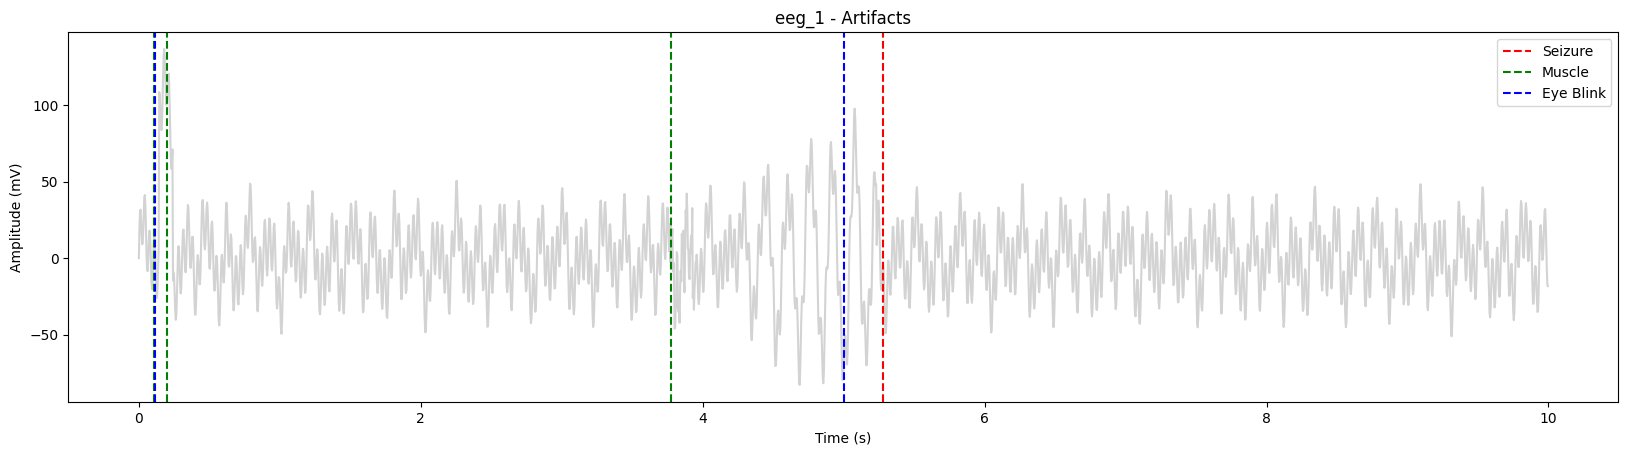

Total detected 6
Total Seizures 1
Seizure onsets [5.28125]
Total Eyeblink 2
Eyeblink onsets [0.1171875  5.00390625]
Total Muscle 3
Muscle onsets [0.109375   0.203125   3.77734375]


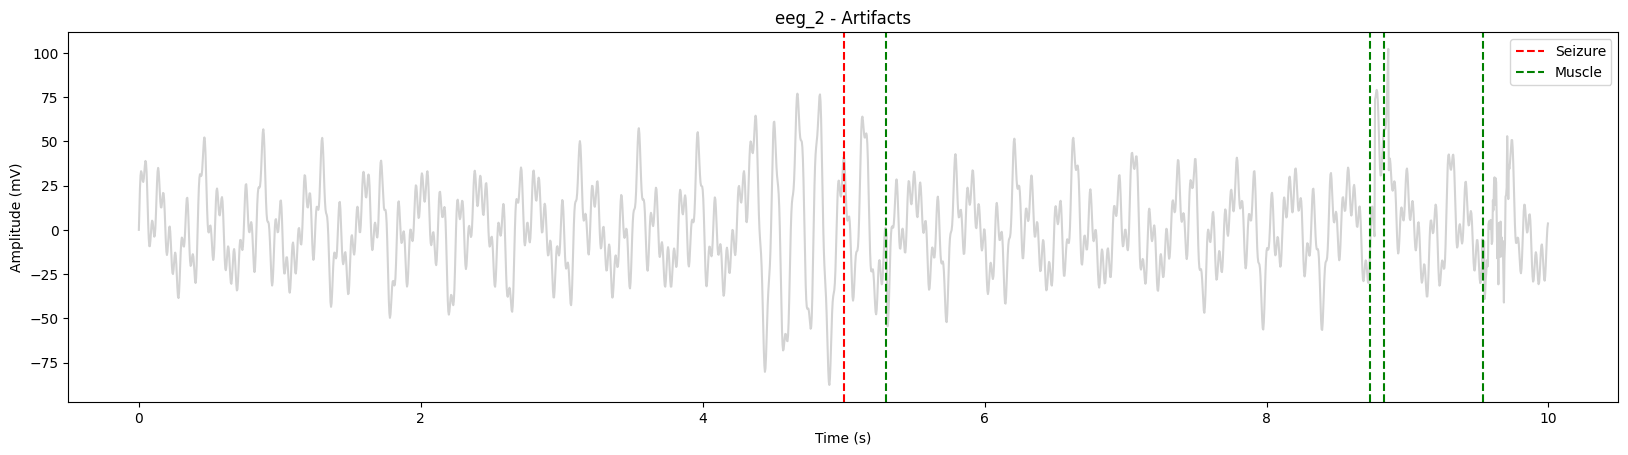

Total detected 5
Total Seizures 1
Seizure onsets [5.00390625]
Total Eyeblink 0
Total Muscle 4
Muscle onsets [5.296875   8.734375   8.83203125 9.53515625]


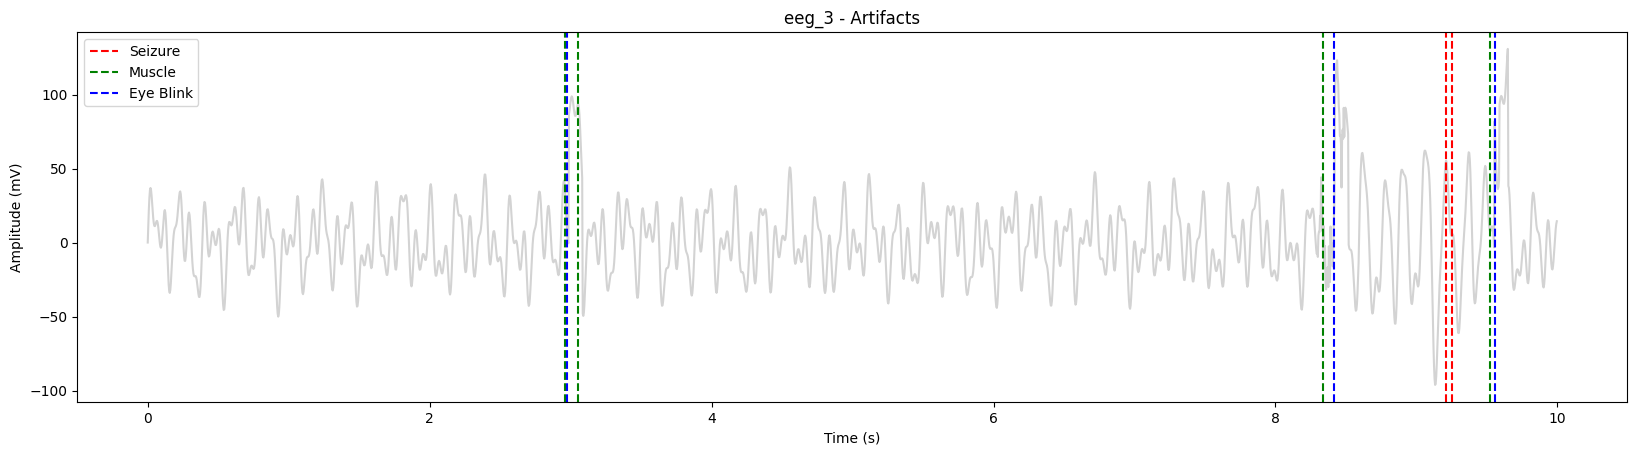

Total detected 9
Total Seizures 2
Seizure onsets [9.20703125 9.25390625]
Total Eyeblink 3
Eyeblink onsets [2.9765625  8.41796875 9.5546875 ]
Total Muscle 4
Muscle onsets [2.9609375 3.0546875 8.3359375 9.5234375]


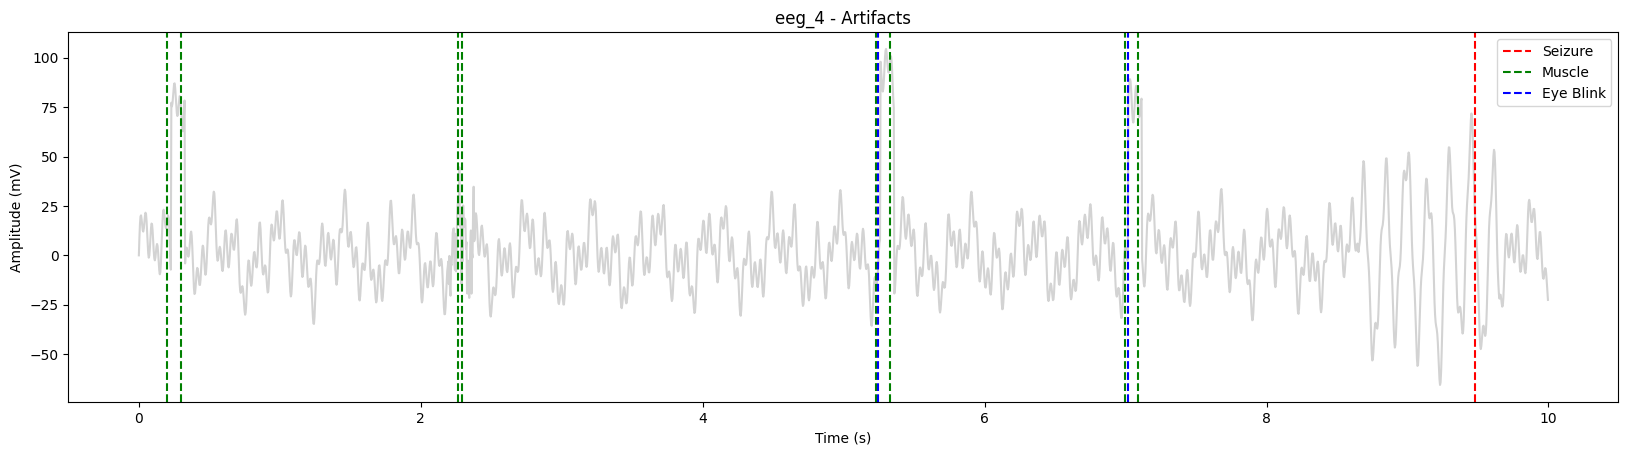

Total detected 11
Total Seizures 1
Seizure onsets [9.4765625]
Total Eyeblink 2
Eyeblink onsets [5.2421875 7.015625 ]
Total Muscle 8
Muscle onsets [0.19921875 0.296875   2.265625   2.29296875 5.23046875 5.328125
 6.9921875  7.08984375]


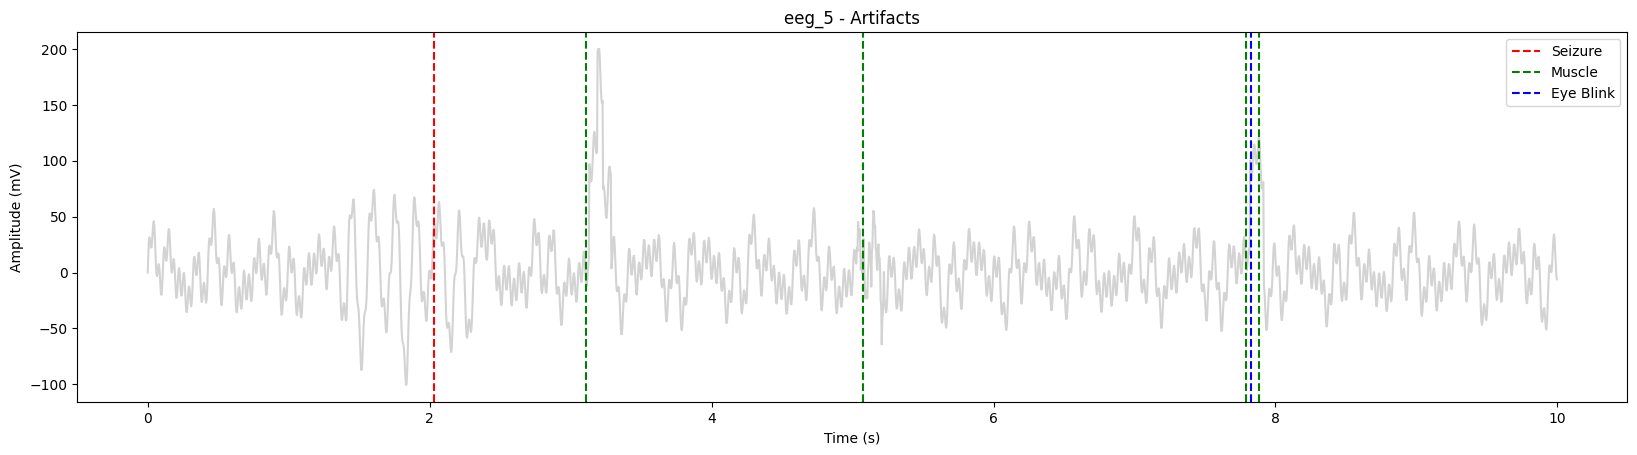

Total detected 6
Total Seizures 1
Seizure onsets [2.03125]
Total Eyeblink 1
Eyeblink onsets [7.82421875]
Total Muscle 4
Muscle onsets [3.109375   5.07421875 7.7890625  7.88671875]


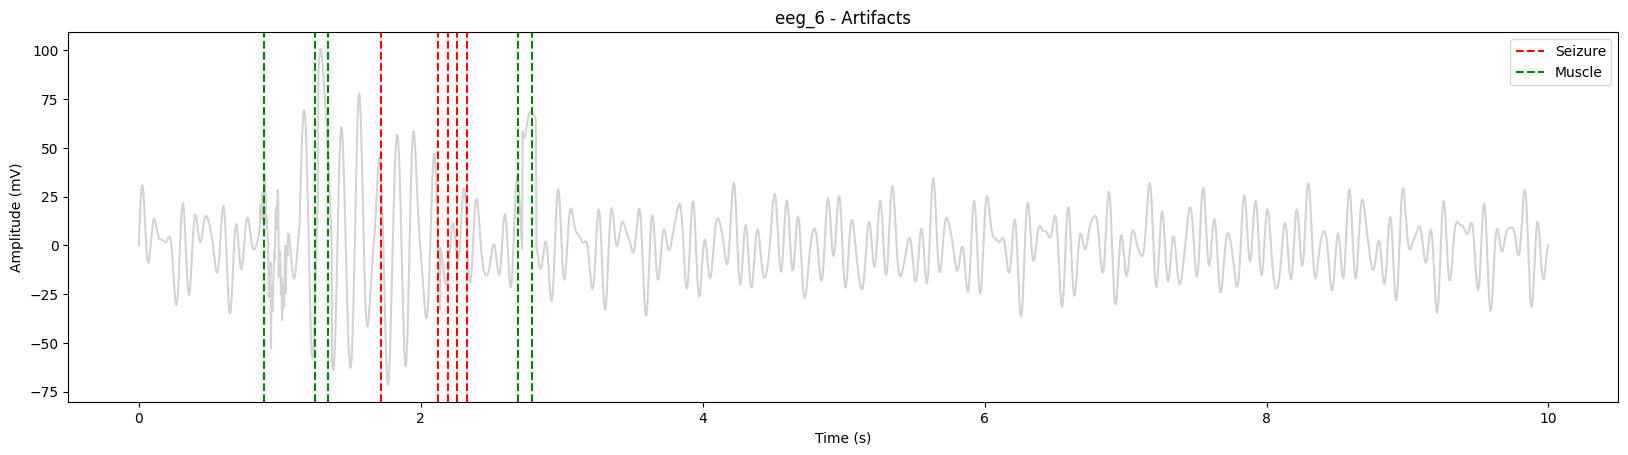

Total detected 10
Total Seizures 5
Seizure onsets [1.71875    2.125      2.19140625 2.2578125  2.328125  ]
Total Eyeblink 0
Total Muscle 5
Muscle onsets [0.88671875 1.25       1.34375    2.69140625 2.7890625 ]


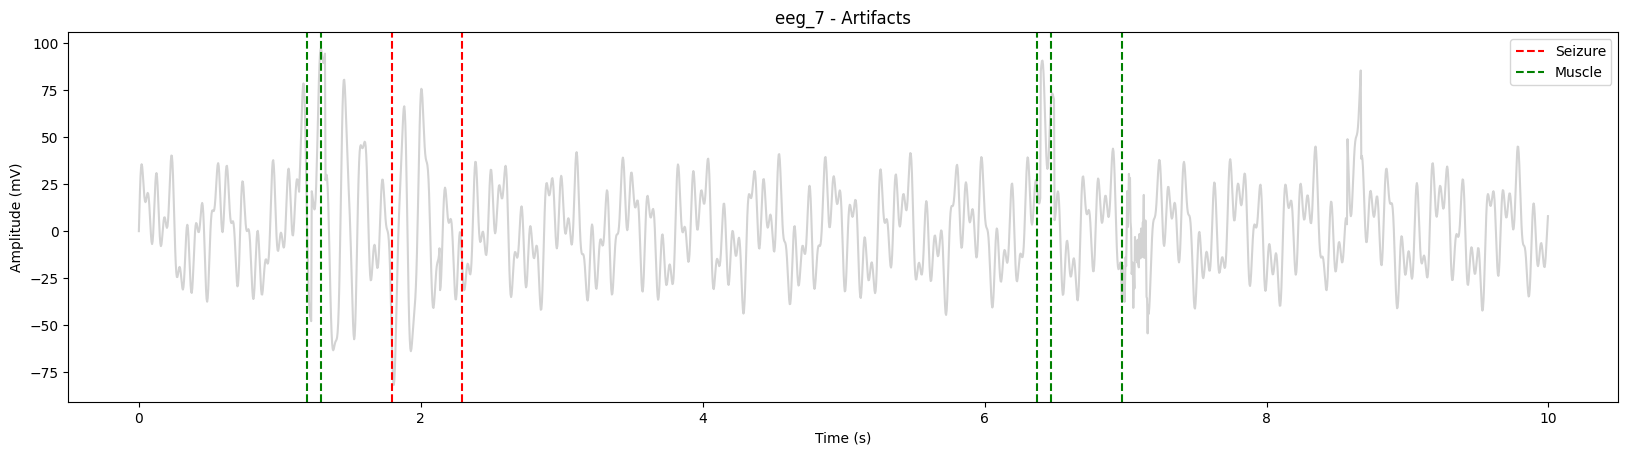

Total detected 7
Total Seizures 2
Seizure onsets [1.79296875 2.2890625 ]
Total Eyeblink 0
Total Muscle 5
Muscle onsets [1.1953125  1.29296875 6.37109375 6.46875    6.9765625 ]


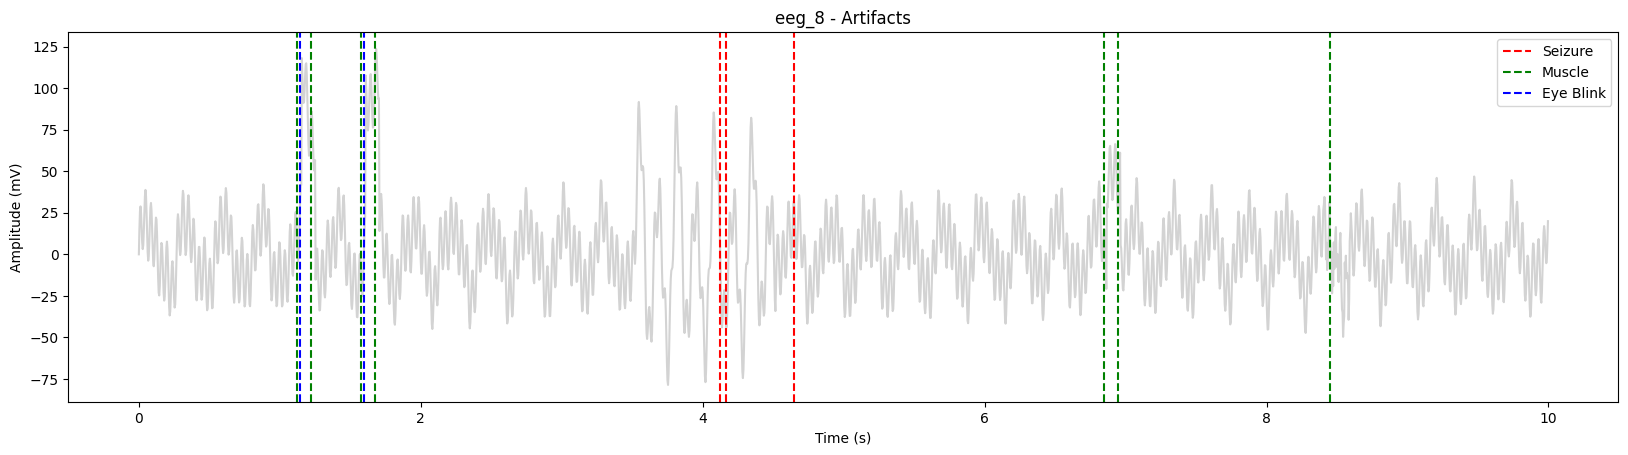

Total detected 12
Total Seizures 3
Seizure onsets [4.12109375 4.1640625  4.64453125]
Total Eyeblink 2
Eyeblink onsets [1.14453125 1.59765625]
Total Muscle 7
Muscle onsets [1.125      1.22265625 1.578125   1.67578125 6.84765625 6.9453125
 8.453125  ]


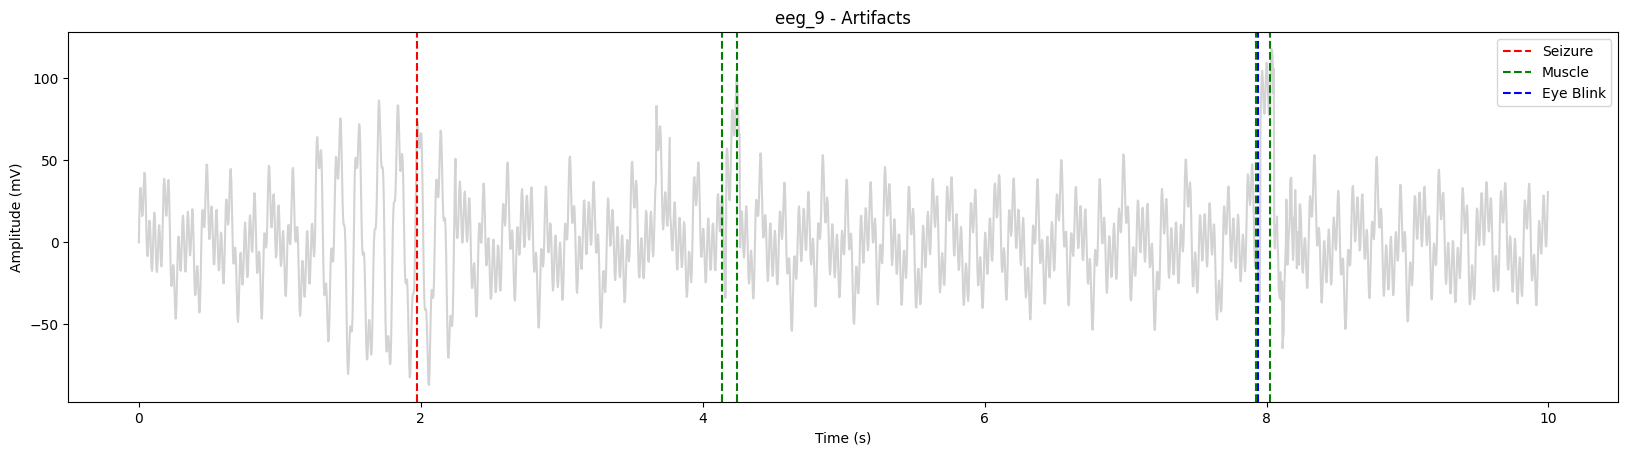

Total detected 6
Total Seizures 1
Seizure onsets [1.97265625]
Total Eyeblink 1
Eyeblink onsets [7.9375]
Total Muscle 4
Muscle onsets [4.13671875 4.2421875  7.921875   8.0234375 ]


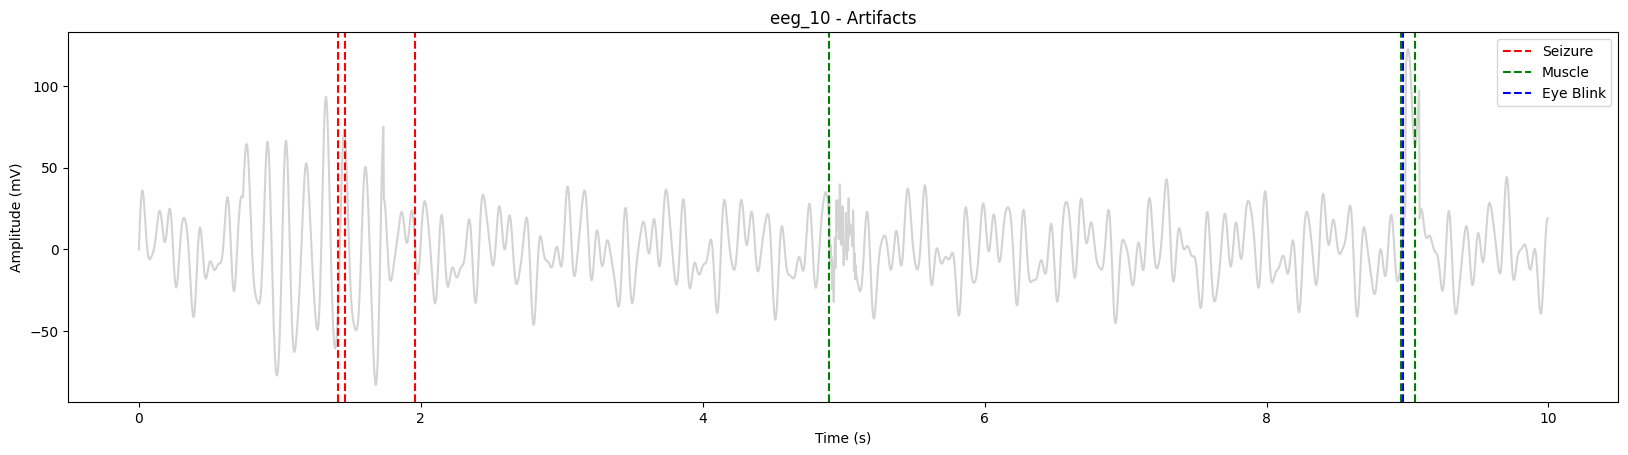

Total detected 7
Total Seizures 3
Seizure onsets [1.41015625 1.4609375  1.95703125]
Total Eyeblink 1
Eyeblink onsets [8.96875]
Total Muscle 3
Muscle onsets [4.8984375  8.95703125 9.05078125]


In [314]:
PLOT_MASK = False
PLOT_TEXTUAL_RESULTS = True

results = []

for sample, fs, signal, time, dt in all_signals: 
  plt.figure().set_figwidth(FIGURE_WIDTH)
  plt.plot(time, signal, color="lightgray")

  seizure_onsets, seizure_mask = seizures(signal)
  muscle_onsets, muscle_mask = muscle(signal)
  eyeblink_onsets, eyeblink_mask = eye_blinks(time, signal, dt)

  if PLOT_MASK:
    plt.plot(time, np.where(seizure_mask, signal, np.nan), "r--", label="Seizure")
  for onset in seizure_onsets:
    plt.axvline(time[onset], color="red", linestyle="--", label="Seizure")

  if PLOT_MASK:
    plt.plot(time, np.where(muscle_mask, signal, np.nan), "g--", label="Muscle")
  for onset in muscle_onsets:
    plt.axvline(time[onset], color="green", linestyle="--", label="Muscle")

  if PLOT_MASK:
    plt.plot(time, np.where(eyeblink_mask, signal, np.nan), "b--", label="Eye Blink")
  for onset in eyeblink_onsets:
    plt.axvline(time[onset], color="blue", linestyle="--", label="Eye Blink")

  # Remove duplicates
  handles, labels = plt.gca().get_legend_handles_labels()
  by_label = dict(zip(labels, handles))
  plt.legend(by_label.values(), by_label.keys())

  plt.title(f"{sample} - Artifacts")
  plt.xlabel("Time (s)")
  plt.ylabel("Amplitude (mV)")
  plt.show()
  
  if PLOT_TEXTUAL_RESULTS:
    print(f"Total detected {len(seizure_onsets)+len(muscle_onsets)+len(eyeblink_onsets)}")
    print(f"Total Seizures {len(seizure_onsets)}")
    if len(seizure_onsets) > 0: 
      print(f"Seizure onsets {time[seizure_onsets]}")
    print(f"Total Eyeblink {len(eyeblink_onsets)}")
    if len(eyeblink_onsets) > 0: 
      print(f"Eyeblink onsets {time[eyeblink_onsets]}")
    print(f"Total Muscle {len(muscle_onsets)}")
    if len(muscle_onsets) > 0: 
      print(f"Muscle onsets {time[muscle_onsets]}")
